In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import sys
sys.path.append('~/Documents/code/yangnet/training/')
print(sys.path)

import pdb
import numpy as np
import numpy.random as npr
import tensorflow as tf
# from tensorflow.python.ops import parallel_for as pfor

import matplotlib.pyplot as plt
from brewer2mpl import qualitative

import task
from task import generate_trials, rule_name
from network import Model, get_perf
# import performance
# import standard_analysis
import tools

import numpy as np
from scipy import linalg as LA
import rcca
import datetime
from sklearn.decomposition import PCA


['', '/home/laura/code/yangnet/analysis/randy data', '/home/laura/code/models/research/lfads', '/home/laura/code/lfads-run-manager/src', '/home/laura/data/join/runs/first_attempt', '/home/laura/data/multitask/train_all', '/home/laura/code/pyrcca', '/home/laura/code/yangnet/training', '/home/laura/miniconda3/envs/py27/lib/python27.zip', '/home/laura/miniconda3/envs/py27/lib/python2.7', '/home/laura/miniconda3/envs/py27/lib/python2.7/plat-linux2', '/home/laura/miniconda3/envs/py27/lib/python2.7/lib-tk', '/home/laura/miniconda3/envs/py27/lib/python2.7/lib-old', '/home/laura/miniconda3/envs/py27/lib/python2.7/lib-dynload', '/home/laura/miniconda3/envs/py27/lib/python2.7/site-packages', '/home/laura/miniconda3/envs/py27/lib/python2.7/site-packages/IPython/extensions', '/home/laura/.ipython', '~/Documents/code/yangnet/training/']


/home/laura/miniconda3/envs/py27/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
def orthogonal_complement(x, normalize=True, threshold=1e-15):
    """Compute orthogonal complement of a matrix

    this works along axis zero, i.e. rank == column rank,
    or number of rows > column rank
    otherwise orthogonal complement is empty

    TODO possibly: use normalize='top' or 'bottom'

    """
    x = np.asarray(x)
    r, c = x.shape
    if r < c:
        import warnings
        warnings.warn('fewer rows than columns', UserWarning)

    # we assume svd is ordered by decreasing singular value, o.w. need sort
    s, v, d = np.linalg.svd(x)
    rank = (v > threshold).sum()

    oc = s[:, rank:]

    if normalize:
        k_oc = oc.shape[1]
        oc = oc.dot(np.linalg.inv(oc[:k_oc, :]))
    return oc

def make_ave_data(data,rad_stim,dim):

    # get ave response
    stim_set = np.unique(rad_stim)
        
    ave_data = np.expand_dims(np.mean(data[:,rad_stim[0,:]==stim_set[0]],axis=1),axis=1)
    for stim in stim_set[1:]:
        ave_data = np.concatenate((ave_data,np.expand_dims(np.mean(data[:,rad_stim[0,:]==stim],axis=1),axis=1)),axis=1)    

    return ave_data, stim_set

def pca_regress_beta_out(ave_data,stim_set,dim):   
    # prep data
    pcar = PCA(n_components=dim)
    pcar.fit(ave_data.T)
    coeff = pcar.components_

    # Regression
    X = pcar.transform(ave_data.T)
    y = np.transpose([np.cos(stim_set), np.sin(stim_set)])
    Xt = np.transpose(X)
    XtX = np.dot(Xt,X)
    Xty = np.dot(Xt,y)
    Beta = np.linalg.solve(XtX,Xty)
     
    return Beta, pcar

def pca_regress_oc_out(ave_data,stim_set,dim):
    pcar = PCA(n_components=dim)
    pcar.fit(ave_data.T)
    coeff = pcar.components_

    # Regression
    X = pcar.transform(ave_data.T)
    y = np.transpose([np.cos(stim_set), np.sin(stim_set)])
    Xt = np.transpose(X)
    XtX = np.dot(Xt,X)
    Xty = np.dot(Xt,y)
    Beta = np.linalg.solve(XtX,Xty)

    oc = orthogonal_complement(Beta)
    
    return oc


def pca_regress_X_reg(oc,pcar,x,y):
    y = np.transpose([np.cos(y), np.sin(y)])
    
    X = pcar.transform(x.T)
    oc_X = np.dot(X, oc)

    oc_Xt = np.transpose(oc_X)
    oc_XtX = np.dot(oc_Xt,oc_X)
    oc_Xty = np.dot(oc_Xt,y)
    oc_Beta = np.linalg.solve(oc_XtX,oc_Xty)

    # x,y output
    x_reg = np.dot(oc_Xt.T,oc_Beta[:,0])
    y_reg = np.dot(oc_Xt.T,oc_Beta[:,1])
    
    return [x_reg,y_reg]

def apply_regress_transform(ave_data,pcar,Beta):

    X = pcar.transform(ave_data.T)
    
    # x,y output
    x_reg = np.dot(X,Beta[:,0])
    y_reg = np.dot(X,Beta[:,1])
    
    return [x_reg,y_reg]
    
         
def gen_X_from_model_dir_epoch(model_dir,rule,epoch,range_size,trial):
    model = Model(model_dir)
    with tf.Session() as sess:
        model.restore()
#         model.cell._sigma=0
        # get all connection weights and biases as tensorflow variables
        var_list = model.var_list
        # evaluate the parameters after training
        params = [sess.run(var) for var in var_list]
        # get hparams
        hparams = model.hp
        # create a trial       
        feed_dict = tools.gen_feed_dict(model, trial, hparams)
        # run model
        h_tf, y_hat_tf = sess.run([model.h, model.y_hat], feed_dict=feed_dict) #(n_time, n_condition, n_neuron)
        if trial.epochs[epoch][1] is None:
            epoch_range = range(np.shape(h_tf)[0]-range_size,np.shape(h_tf)[0])
        else:
            epoch_range = range(trial.epochs[epoch][1]-range_size,trial.epochs[epoch][1])
        x = np.transpose(h_tf[epoch_range,:,:],(2,1,0))
        X = np.reshape(x,(x.shape[0],-1))
    return X, trial    #return hidden unit activity

def gen_X_from_model_dir(model_dir,rule):
    model = Model(model_dir)
    with tf.Session() as sess:
        model.restore()
#         model.cell._sigma=0
        # get all connection weights and biases as tensorflow variables
        var_list = model.var_list
        # evaluate the parameters after training
        params = [sess.run(var) for var in var_list]
        # get hparams
        hparams = model.hp
        # create a trial
        trial = generate_trials(rule, hparams, mode='test', noise_on=False, batch_size =500)        
        feed_dict = tools.gen_feed_dict(model, trial, hparams)
        # run model
        h_tf, y_hat_tf = sess.run([model.h, model.y_hat], feed_dict=feed_dict) #(n_time, n_condition, n_neuron)
        x = np.transpose(h_tf[:,:,:],(2,1,0))
        X = np.reshape(x,(x.shape[0],-1))
    return X, trial    #return hidden unit activity

def gen_trials_from_model_dir(model_dir,rule):
    model = Model(model_dir)
    with tf.Session() as sess:
        model.restore()
# # # #         model.cell._sigma=0
        # get all connection weights and biases as tensorflow variables
        var_list = model.var_list
        # evaluate the parameters after training
#         params = [sess.run(var) for var in var_list]
        # get hparams
        hparams = model.hp
        # create a trial
        trial = generate_trials(rule, hparams, mode='random', noise_on=False, batch_size =500, long_delay =1)
    return trial

# def load_X_from_model_dir(model_dir,trial):
#     model = Model(model_dir)
#     with tf.Session() as sess:
#         model.restore()
# #         model.cell._sigma=0
#         # get all connection weights and biases as tensorflow variables
#         var_list = model.var_list
#         # evaluate the parameters after training
#         params = [sess.run(var) for var in var_list]
#         w_out = params[2]
#         hparams = model.hp
#         feed_dict = tools.gen_feed_dict(model, trial, hparams)
#         # run model
#         h_tf, y_hat_tf = sess.run([model.h, model.y_hat], feed_dict=feed_dict) #(n_time, n_condition, n_neuron)
#         x = np.transpose(h_tf,(2,1,0))
#         X = np.reshape(x,(x.shape[0],-1))
#     return X    #return orthogonal complement of hidden unit activity to ouput projection matrix
         
def gen_stim_loc(trial):
    stim_locs = trial.stim_locs
    return stim_locs

def gen_stim_loc_delaydm():
    n_stim_loc, n_stim1_strength = batch_shape = 20, 5
    batch_size = np.prod(batch_shape)
    ind_stim_loc, ind_stim1_strength = np.unravel_index(range(batch_size),batch_shape)

    stim1_locs = 2*np.pi*ind_stim_loc/n_stim_loc
    stim2_locs = (stim1_locs+np.pi)%(2*np.pi)
    stim1_strengths = 1.0*ind_stim1_strength/n_stim1_strength+0.5
    stim2_strengths = 2 - stim1_strengths
    coh = stim1_strengths - stim2_strengths
    return stim1_locs, coh
        
def motor_null_space(model_dir,model_n):
    model = Model(model_dir)
    with tf.Session() as sess:
        model.restore()
#         model.cell._sigma=0
        # get all connection weights and biases as tensorflow variables
        var_list = model.var_list
        # evaluate the parameters after training
        params = [sess.run(var) for var in var_list]
        w_out = params[2]
    return w_out

def input_null_space(model_dir,model_n):
    model = Model(model_dir)
    with tf.Session() as sess:
        model.restore()
#         model.cell._sigma=0
        # get all connection weights and biases as tensorflow variables
        var_list = model.var_list
        # evaluate the parameters after training
        params = [sess.run(var) for var in var_list]
        w_in = params[0][0:85,:].T # inputs and then state
    return w_in

In [6]:
# shape data
rule1 = 'delayanti'
rule2 = 'delaygo'
range_size = 30
X_reg_11 = {}
X_reg_12 = {}
dim = 20
model_n = 6

model_path = '/home/laura/data/multitask/train_all'z
model_dir = os.path.join(model_path, str(model_n))

_, trial = gen_X_from_model_dir(os.path.join(model_path, str(0)),rule1)
stim_locs = gen_stim_loc(trial)
stim_locs_rep = np.matlib.repmat(stim_locs, range_size, 1)
stim_locs_Y = np.reshape(stim_locs_rep.T,(1,-1))

for epoch1 in ['stim1','delay1','go1']:
    data, trial = gen_X_from_model_dir_epoch(model_dir,rule1,epoch1,range_size)
    ave_data, stim_set = make_ave_data(data,stim_locs_Y,dim)
    Beta, pcar = pca_regress_beta_out(ave_data,stim_set,dim)
    for epoch2 in['stim1','delay1','go1']:
        data, trial = gen_X_from_model_dir_epoch(model_dir,rule1,epoch2,range_size)
        ave_data, stim_set = make_ave_data(data,stim_locs_Y,dim)
        X_reg_11[epoch1,epoch2] = apply_regress_transform(data,pcar,Beta)
        
        data, trial = gen_X_from_model_dir_epoch(model_dir,rule2,epoch2,range_size)
        ave_data, stim_set = make_ave_data(data,stim_locs_Y,dim)
        X_reg_12[epoch1,epoch2] = apply_regress_transform(data,pcar,Beta)

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>


InternalError: CUDA runtime implicit initialization on GPU:0 failed. Status: out of memory

/home/laura/miniconda3/envs/py27/lib/python2.7/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


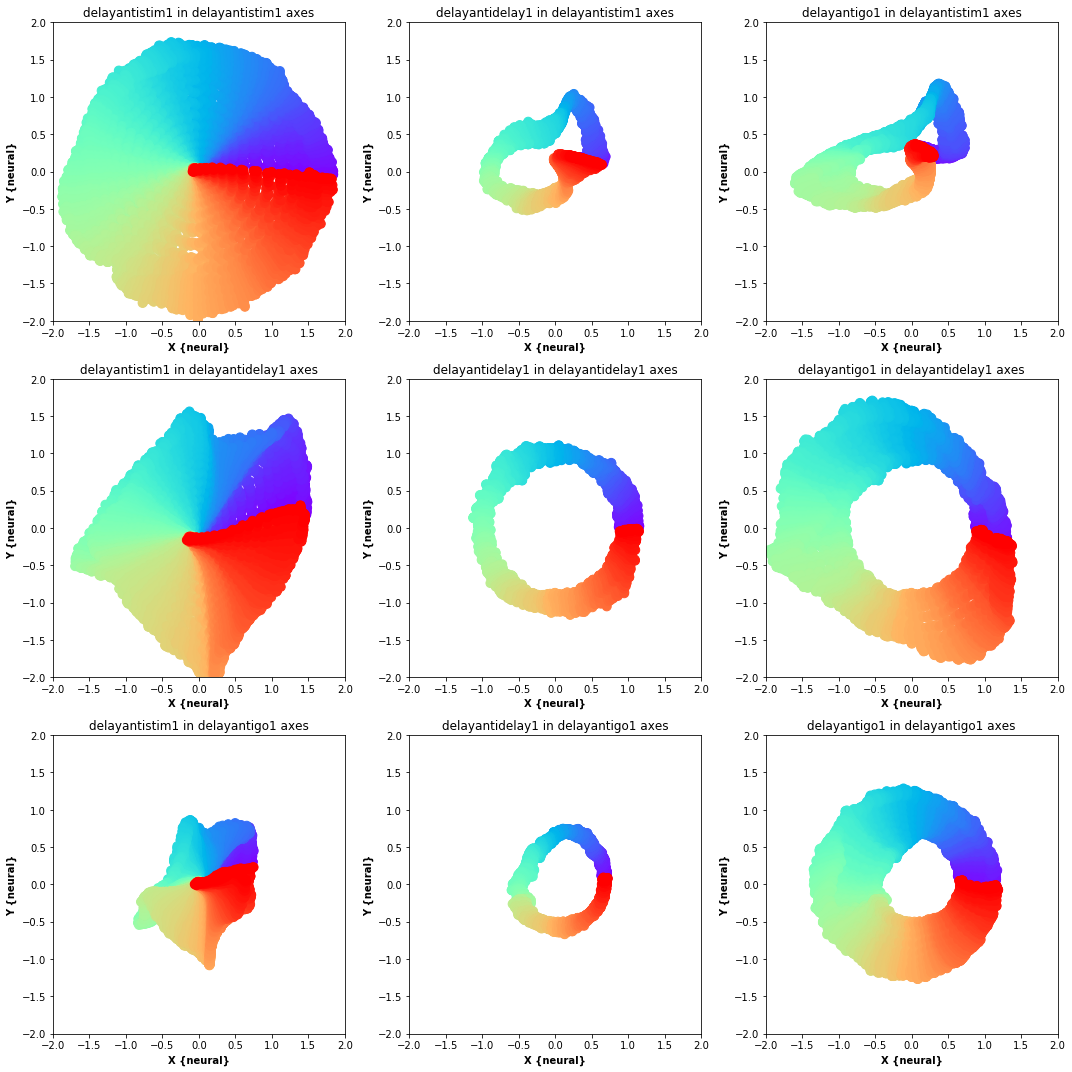

In [4]:
FIG_WIDTH = 15 # inches
FIG_HEIGHT = 15 # inches
FONT_WEIGHT = 'bold'
fig = plt.figure(figsize=(FIG_WIDTH, FIG_HEIGHT),tight_layout=True,facecolor='white')

x = 0
for epoch1 in ['stim1','delay1','go1']:
    for epoch2 in['stim1','delay1','go1']:
        x+=1
        ax = fig.add_subplot(3,3,x)
        plt.scatter(X_reg_11[epoch1,epoch2][0],X_reg_11[epoch1,epoch2][1],s =80,c=np.squeeze((stim_locs_Y*100)), marker='o', cmap='rainbow')
        ax.set_xlim(-2, 2)
        ax.set_ylim(-2, 2)
        ax.set_xlabel('X {neural}', fontweight=FONT_WEIGHT)
        ax.set_ylabel('Y {neural}', fontweight=FONT_WEIGHT)
        ax.set_title(rule1 + epoch2 + ' in ' + rule1 + epoch1 + ' axes')

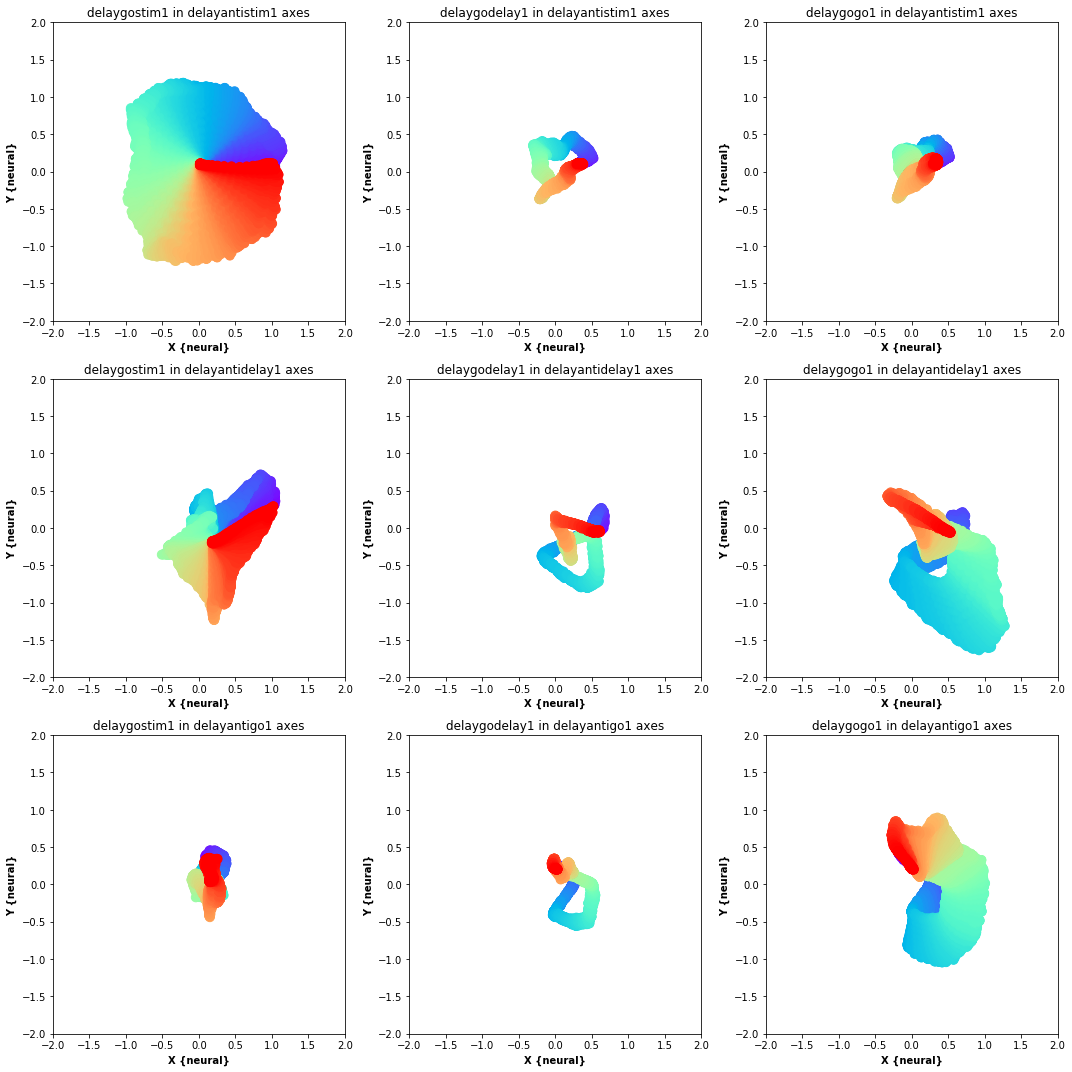

In [5]:
FIG_WIDTH = 15 # inches
FIG_HEIGHT = 15 # inches
FONT_WEIGHT = 'bold'
fig = plt.figure(figsize=(FIG_WIDTH, FIG_HEIGHT),tight_layout=True,facecolor='white')

x = 0
for epoch1 in ['stim1','delay1','go1']:
    for epoch2 in['stim1','delay1','go1']:
        x+=1
        ax = fig.add_subplot(3,3,x)
        plt.scatter(X_reg_12[epoch1,epoch2][0],X_reg_12[epoch1,epoch2][1],s =80,c=np.squeeze((stim_locs_Y*100)), marker='o', cmap='rainbow')
        ax.set_xlim(-2, 2)
        ax.set_ylim(-2, 2)
        ax.set_xlabel('X {neural}', fontweight=FONT_WEIGHT)
        ax.set_ylabel('Y {neural}', fontweight=FONT_WEIGHT)
        ax.set_title(rule2 + epoch2 + ' in ' + rule1 + epoch1 + ' axes')

In [6]:
X_reg_11_oc = {}
X_reg_12_oc = {}

model_path = '/home/laura/data/multitask/train_all'
model_dir = os.path.join(model_path, str(model_n))
w_out = motor_null_space(model_dir,model_n)
oc_w_out = orthogonal_complement(w_out)

for epoch1 in ['stim1','delay1','go1']:
    data, trial = gen_X_from_model_dir_epoch(model_dir,rule1,epoch1,range_size)
    data_oc = np.dot(oc_w_out.T,data)
    ave_data, stim_set = make_ave_data(data_oc,stim_locs_Y,dim)
    Beta, pcar = pca_regress_beta_out(ave_data,stim_set,dim)
    for epoch2 in['stim1','delay1','go1']:
        data, trial = gen_X_from_model_dir_epoch(model_dir,rule1,epoch2,range_size)
        data_oc = np.dot(oc_w_out.T,data)
        X_reg_11_oc[epoch1,epoch2] = apply_regress_transform(data_oc,pcar,Beta)
        
        data, trial = gen_X_from_model_dir_epoch(model_dir,rule2,epoch2,range_size)
        data_oc = np.dot(oc_w_out.T,data)
        X_reg_12_oc[epoch1,epoch2] = apply_regress_transform(data_oc,pcar,Beta)


INFO:tensorflow:Restoring parameters from /home/laura/data/multitask/train_all/6/model.ckpt
Model restored from file: /home/laura/data/multitask/train_all/6/model.ckpt
INFO:tensorflow:Restoring parameters from /home/laura/data/multitask/train_all/6/model.ckpt
Model restored from file: /home/laura/data/multitask/train_all/6/model.ckpt
INFO:tensorflow:Restoring parameters from /home/laura/data/multitask/train_all/6/model.ckpt
Model restored from file: /home/laura/data/multitask/train_all/6/model.ckpt
INFO:tensorflow:Restoring parameters from /home/laura/data/multitask/train_all/6/model.ckpt
Model restored from file: /home/laura/data/multitask/train_all/6/model.ckpt
INFO:tensorflow:Restoring parameters from /home/laura/data/multitask/train_all/6/model.ckpt
Model restored from file: /home/laura/data/multitask/train_all/6/model.ckpt
INFO:tensorflow:Restoring parameters from /home/laura/data/multitask/train_all/6/model.ckpt
Model restored from file: /home/laura/data/multitask/train_all/6/mod

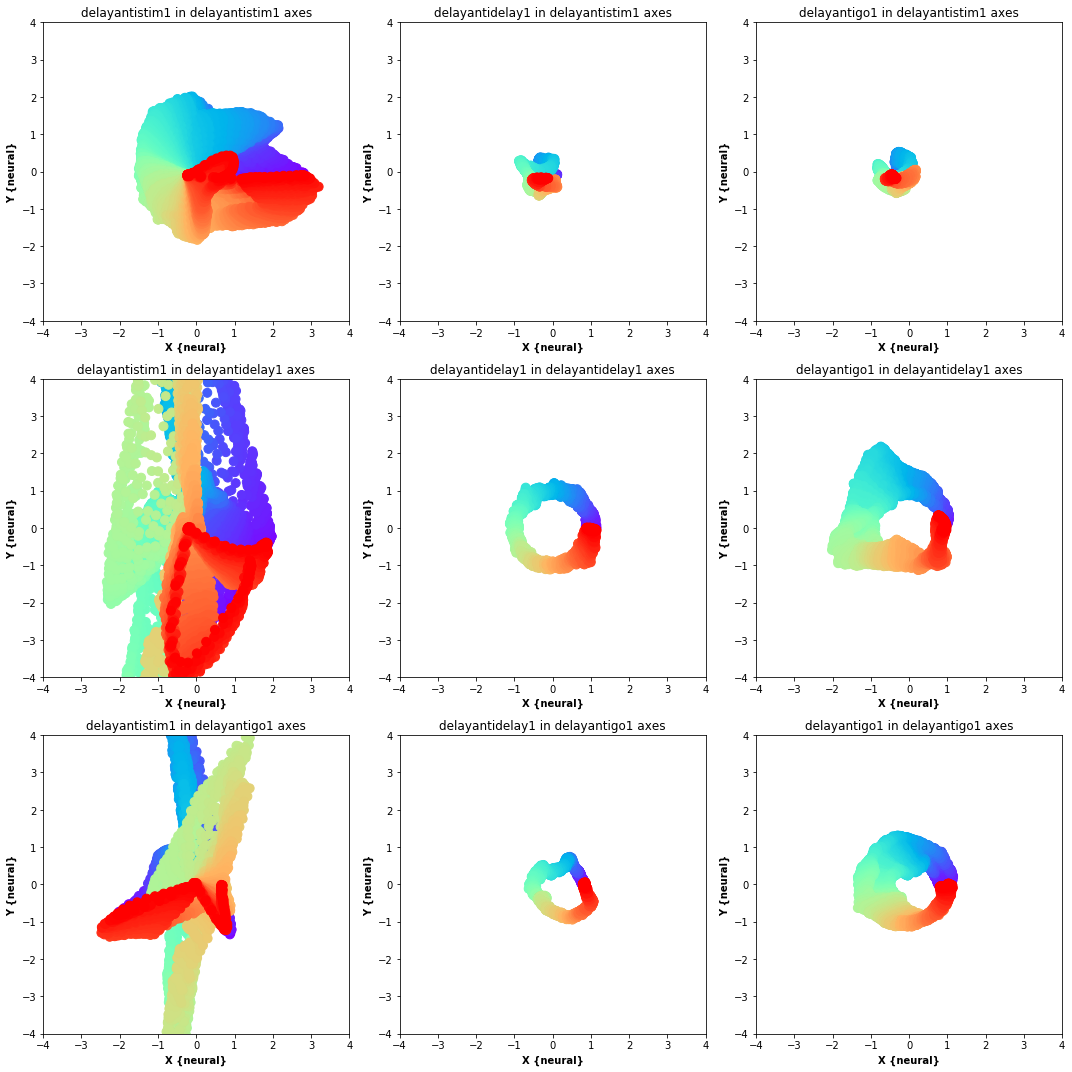

In [7]:
FIG_WIDTH = 15 # inches
FIG_HEIGHT = 15 # inches
FONT_WEIGHT = 'bold'
fig = plt.figure(figsize=(FIG_WIDTH, FIG_HEIGHT),tight_layout=True,facecolor='white')

x = 0
for epoch1 in ['stim1','delay1','go1']:
    for epoch2 in['stim1','delay1','go1']:
        x+=1
        ax = fig.add_subplot(3,3,x)
        plt.scatter(X_reg_11_oc[epoch1,epoch2][0],X_reg_11_oc[epoch1,epoch2][1],s =80,c=np.squeeze((stim_locs_Y*100)), marker='o', cmap='rainbow')
        ax.set_xlabel('X {neural}', fontweight=FONT_WEIGHT)
        ax.set_ylabel('Y {neural}', fontweight=FONT_WEIGHT)
        ax.set_title(rule1 + epoch2 + ' in ' + rule1 + epoch1 + ' axes')
        ax.set_xlim(-4, 4)
        ax.set_ylim(-4, 4)

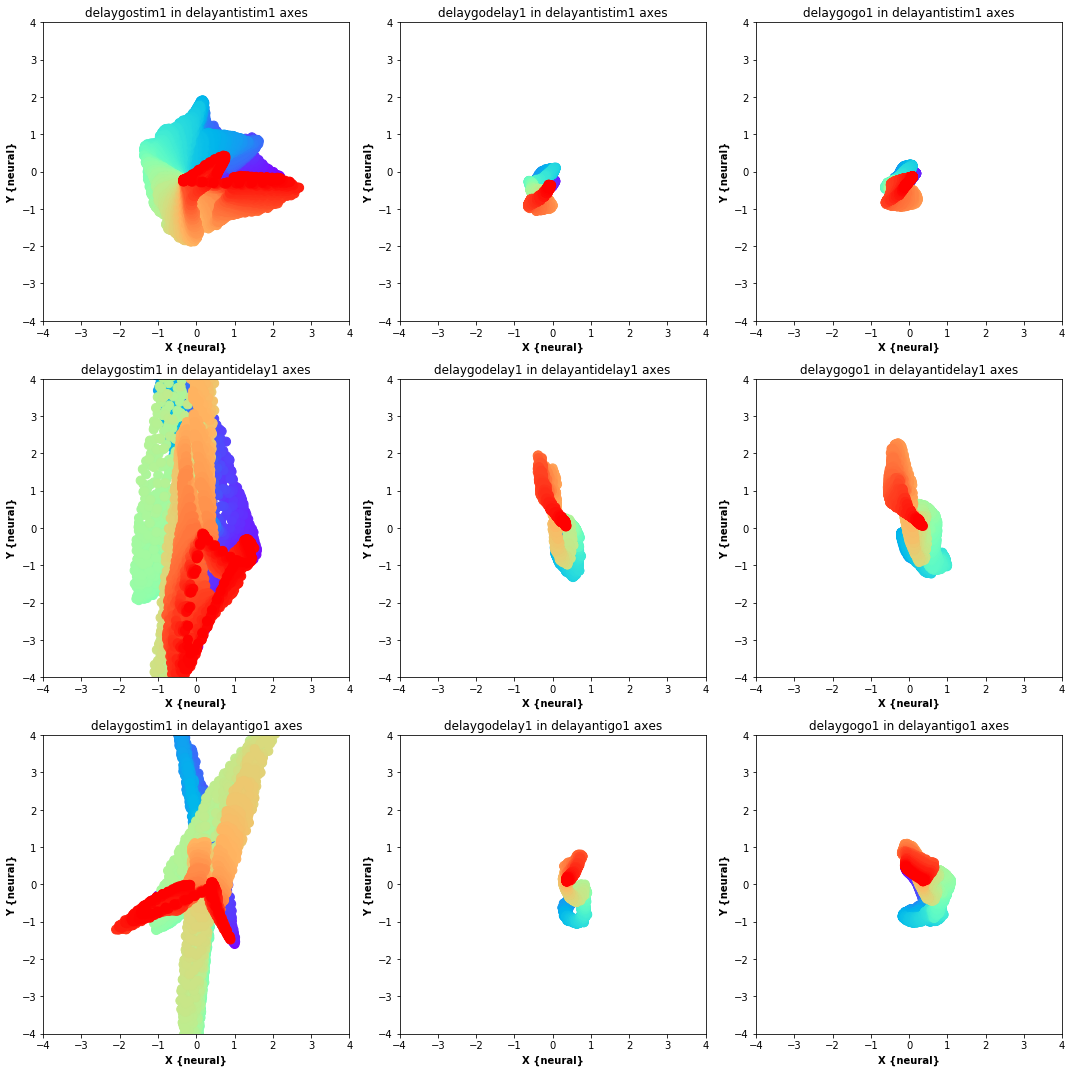

In [8]:
FIG_WIDTH = 15 # inches
FIG_HEIGHT = 15 # inches
FONT_WEIGHT = 'bold'
fig = plt.figure(figsize=(FIG_WIDTH, FIG_HEIGHT),tight_layout=True,facecolor='white')

x = 0
for epoch1 in ['stim1','delay1','go1']:
    for epoch2 in['stim1','delay1','go1']:
        x+=1
        ax = fig.add_subplot(3,3,x)
        plt.scatter(X_reg_12_oc[epoch1,epoch2][0],X_reg_12_oc[epoch1,epoch2][1],s =80,c=np.squeeze((stim_locs_Y*100)), marker='o', cmap='rainbow')
        ax.set_xlabel('X {neural}', fontweight=FONT_WEIGHT)
        ax.set_ylabel('Y {neural}', fontweight=FONT_WEIGHT)
        ax.set_title(rule2 + epoch2 + ' in ' + rule1 + epoch1 + ' axes')
        ax.set_xlim(-4, 4)
        ax.set_ylim(-4, 4)

In [4]:
FIG_WIDTH = 15 # inches
FIG_HEIGHT = 15 # inches
FONT_WEIGHT = 'bold'

# shape data
rule1 = 'delayanti'
rule2 = 'delaygo'
range_size = 30
X_reg_11 = {}
X_reg_12 = {}
dim = 20
model_n = 4

X_reg_11_oc = {}
X_reg_12_oc = {}

model_path = '/home/laura/data/multitask/train_all'
model_dir = os.path.join(model_path, str(model_n))
w_out = motor_null_space(model_dir,model_n)
oc_w_out = orthogonal_complement(w_out)

data, trial = gen_X_from_model_dir(model_dir,rule1)
stim_locs = gen_stim_loc(trial)
stim_locs_rep = np.matlib.repmat(stim_locs, trial.y.shape[0], 1)
stim_locs_Y = np.reshape(stim_locs_rep.T,(1,-1))
# data_oc = np.dot(oc_w_out.T,data)
# ave_data, stim_set = make_ave_data(data_oc,stim_locs_Y,dim)
    
uptrial = stim_locs_Y==0
downtrial = np.abs(stim_locs_Y-np.pi)<.01

pcar = PCA(n_components=30)
pcar.fit(data[:,np.squeeze(uptrial+downtrial)].T)
X = pcar.transform(data.T)

color = ['r','r','b','b','r','r','b','b']
dash = ['-','-','-','-',':',':',':',':']

fig = plt.figure(figsize=(15, 15),tight_layout=True,facecolor='white')
for t in range(8):
    inds = range(trial.y.shape[0]*t, trial.y.shape[0]*(t+1)) 
    
    for pc in range(20):
        ax = fig.add_subplot(10,2,pc)
        plt.plot(range(trial.y.shape[0]),X[inds,pc],dash[t]+color[t],linewidth=2)
        plt.plot(X[inds[0]-1+trial.epochs['stim1'][0],pc1],X[inds[0]-1+trial.epochs['stim1'][0],pc2],'ok',markersize=12)
        plt.plot(X[inds[0]-1+trial.epochs['stim1'][1],pc1],X[inds[0]-1+trial.epochs['stim1'][1],pc2],'o',color = (.25,.25,.25),markersize=12)
        plt.plot(X[inds[0]-1+trial.epochs['go1'][0],pc1],X[inds[0]-1+trial.epochs['go1'][0],pc2],'o',color = (.5,.5,.5), markersize=12)
        plt.plot(X[inds[0]-1+trial.y.shape[0],pc1],X[inds[0]-1+trial.y.shape[0],pc2],'o',color = (.75,.75,.75), markersize=12)
        ax.set_xlabel('PC '+ str(pc1+1), fontweight=FONT_WEIGHT)
        ax.set_ylabel('PC '+ str(pc2+1), fontweight=FONT_WEIGHT)
#         ax.set_xlim(-2, 2)
#         ax.set_ylim(-2, 2)


Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(341, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 33) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(33,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /home/laura/data/multitask/train_all/4/model.ckpt
INFO:tensorflow:Restoring parameters from /home/laura/data/multitask/train_all/4/model.ckpt
Model restored from file: /home/laura/data/multitask/train_all/4/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(341, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 33) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(33,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /home/laura/data/multitask/train_all/4/model.ckpt
INFO:tensorflow:Restoring parame

InternalError: Blas GEMM launch failed : a.shape=(40, 341), b.shape=(341, 256), m=40, n=256, k=341
	 [[{{node rnn/while/rnn/leaky_rnn_cell/MatMul}} = MatMul[T=DT_FLOAT, transpose_a=false, transpose_b=false, _device="/job:localhost/replica:0/task:0/device:GPU:0"](rnn/while/rnn/leaky_rnn_cell/concat, rnn/while/rnn/leaky_rnn_cell/MatMul/Enter)]]
	 [[{{node rnn/TensorArrayStack/TensorArrayGatherV3/_55}} = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_155_rnn/TensorArrayStack/TensorArrayGatherV3", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]

Caused by op u'rnn/while/rnn/leaky_rnn_cell/MatMul', defined at:
  File "/home/laura/miniconda3/envs/py27/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/home/laura/miniconda3/envs/py27/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/home/laura/miniconda3/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/laura/miniconda3/envs/py27/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/laura/miniconda3/envs/py27/lib/python2.7/site-packages/ipykernel/kernelapp.py", line 486, in start
    self.io_loop.start()
  File "/home/laura/miniconda3/envs/py27/lib/python2.7/site-packages/tornado/ioloop.py", line 1064, in start
    handler_func(fd_obj, events)
  File "/home/laura/miniconda3/envs/py27/lib/python2.7/site-packages/tornado/stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/laura/miniconda3/envs/py27/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "/home/laura/miniconda3/envs/py27/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/laura/miniconda3/envs/py27/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "/home/laura/miniconda3/envs/py27/lib/python2.7/site-packages/tornado/stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/laura/miniconda3/envs/py27/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/laura/miniconda3/envs/py27/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/laura/miniconda3/envs/py27/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/home/laura/miniconda3/envs/py27/lib/python2.7/site-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/laura/miniconda3/envs/py27/lib/python2.7/site-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/laura/miniconda3/envs/py27/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2714, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/laura/miniconda3/envs/py27/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2818, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/laura/miniconda3/envs/py27/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2878, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-4-3a77bc933558>", line 22, in <module>
    data, trial = gen_X_from_model_dir(model_dir,rule1)
  File "<ipython-input-3-950084ab0163>", line 126, in gen_X_from_model_dir
    model = Model(model_dir)
  File "/home/laura/code/yangnet/training/network.py", line 474, in __init__
    self._build(hp)
  File "/home/laura/code/yangnet/training/network.py", line 483, in _build
    self._build_fused(hp)
  File "/home/laura/code/yangnet/training/network.py", line 569, in _build_fused
    cell, self.x, dtype=tf.float32, time_major=True)
  File "/home/laura/miniconda3/envs/py27/lib/python2.7/site-packages/tensorflow/python/ops/rnn.py", line 664, in dynamic_rnn
    dtype=dtype)
  File "/home/laura/miniconda3/envs/py27/lib/python2.7/site-packages/tensorflow/python/ops/rnn.py", line 868, in _dynamic_rnn_loop
    swap_memory=swap_memory)
  File "/home/laura/miniconda3/envs/py27/lib/python2.7/site-packages/tensorflow/python/ops/control_flow_ops.py", line 3274, in while_loop
    return_same_structure)
  File "/home/laura/miniconda3/envs/py27/lib/python2.7/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2994, in BuildLoop
    pred, body, original_loop_vars, loop_vars, shape_invariants)
  File "/home/laura/miniconda3/envs/py27/lib/python2.7/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2929, in _BuildLoop
    body_result = body(*packed_vars_for_body)
  File "/home/laura/miniconda3/envs/py27/lib/python2.7/site-packages/tensorflow/python/ops/control_flow_ops.py", line 3243, in <lambda>
    body = lambda i, lv: (i + 1, orig_body(*lv))
  File "/home/laura/miniconda3/envs/py27/lib/python2.7/site-packages/tensorflow/python/ops/rnn.py", line 836, in _time_step
    (output, new_state) = call_cell()
  File "/home/laura/miniconda3/envs/py27/lib/python2.7/site-packages/tensorflow/python/ops/rnn.py", line 822, in <lambda>
    call_cell = lambda: cell(input_t, state)
  File "/home/laura/miniconda3/envs/py27/lib/python2.7/site-packages/tensorflow/python/ops/rnn_cell_impl.py", line 233, in __call__
    return super(RNNCell, self).__call__(inputs, state)
  File "/home/laura/miniconda3/envs/py27/lib/python2.7/site-packages/tensorflow/python/layers/base.py", line 364, in __call__
    outputs = super(Layer, self).__call__(inputs, *args, **kwargs)
  File "/home/laura/miniconda3/envs/py27/lib/python2.7/site-packages/tensorflow/python/keras/engine/base_layer.py", line 769, in __call__
    outputs = self.call(inputs, *args, **kwargs)
  File "/home/laura/code/yangnet/training/network.py", line 207, in call
    array_ops.concat([inputs, state], 1), self._kernel)
  File "/home/laura/miniconda3/envs/py27/lib/python2.7/site-packages/tensorflow/python/ops/math_ops.py", line 2053, in matmul
    a, b, transpose_a=transpose_a, transpose_b=transpose_b, name=name)
  File "/home/laura/miniconda3/envs/py27/lib/python2.7/site-packages/tensorflow/python/ops/gen_math_ops.py", line 4560, in mat_mul
    name=name)
  File "/home/laura/miniconda3/envs/py27/lib/python2.7/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/home/laura/miniconda3/envs/py27/lib/python2.7/site-packages/tensorflow/python/util/deprecation.py", line 488, in new_func
    return func(*args, **kwargs)
  File "/home/laura/miniconda3/envs/py27/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 3272, in create_op
    op_def=op_def)
  File "/home/laura/miniconda3/envs/py27/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 1768, in __init__
    self._traceback = tf_stack.extract_stack()

InternalError (see above for traceback): Blas GEMM launch failed : a.shape=(40, 341), b.shape=(341, 256), m=40, n=256, k=341
	 [[{{node rnn/while/rnn/leaky_rnn_cell/MatMul}} = MatMul[T=DT_FLOAT, transpose_a=false, transpose_b=false, _device="/job:localhost/replica:0/task:0/device:GPU:0"](rnn/while/rnn/leaky_rnn_cell/concat, rnn/while/rnn/leaky_rnn_cell/MatMul/Enter)]]
	 [[{{node rnn/TensorArrayStack/TensorArrayGatherV3/_55}} = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_155_rnn/TensorArrayStack/TensorArrayGatherV3", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]


In [273]:
print(w_out.shape,w_in.shape)

(256, 33) (341, 256)


In [12]:
X_stim_11_oc = {}
X_stim_12_oc = {}
X_motor_11_oc = {}
X_motor_12_oc = {}

# shape data
rule1 = 'delayanti'
rule2 = 'delaygo'
range_size = 30
dim = 30
model_n = 7

model_path = '/home/laura/data/multitask/train_all'
model_dir = os.path.join(model_path, str(model_n))

w_out = motor_null_space(model_dir,model_n)
oc_w_out = orthogonal_complement(w_out)

w_in = input_null_space(model_dir,model_n)
oc_w_in = orthogonal_complement(w_in)

stim_locs_rep = np.matlib.repmat(stim_locs, range_size, 1)
stim_locs_Y = np.reshape(stim_locs_rep.T,(1,-1))
stim_locs_Y_double = np.concatenate((stim_locs_Y,stim_locs_Y),axis=1)
targ_locs_Y_double = np.concatenate((stim_locs_Y,stim_locs_Y+np.pi),axis=1)

for epoch1 in ['stim1','delay1','go1']:
    data1, trial = gen_X_from_model_dir_epoch(model_dir,rule1,epoch1,range_size)    
    data2, trial = gen_X_from_model_dir_epoch(model_dir,rule2,epoch1,range_size)
    
    data = np.concatenate((data1,data2),axis=1)
    
    data_oc = np.dot(oc_w_out.T,data)
    data_oc = np.dot(oc_w_in.T,data)
#     data_oc = data
    
    ave_data_stim, stim_set = make_ave_data(data_oc,stim_locs_Y_double,dim)
    ave_data_targ, targ_set = make_ave_data(data_oc,targ_locs_Y_double,dim)
    
    Beta_stim, pcar_stim = pca_regress_beta_out(ave_data_stim,stim_set,dim)
    Beta_targ, pcar_targ = pca_regress_beta_out(ave_data_targ,targ_set,dim)
    
    for epoch2 in['stim1','delay1','go1']:
        data, trial = gen_X_from_model_dir_epoch(model_dir,rule1,epoch2,range_size)
        data_oc = np.dot(oc_w_out.T,data)
        data_oc = np.dot(oc_w_in.T,data)
#         data_oc = data
        
        X_stim_11_oc[epoch1,epoch2] = apply_regress_transform(data_oc,pcar_stim,Beta_stim)
        X_motor_11_oc[epoch1,epoch2] = apply_regress_transform(data_oc,pcar_targ,Beta_targ)
        
        data, trial = gen_X_from_model_dir_epoch(model_dir,rule2,epoch2,range_size)
        data_oc = np.dot(oc_w_out.T,data)
        data_oc = np.dot(oc_w_in.T,data)
#         data_oc = data
    
        X_stim_12_oc[epoch1,epoch2] = apply_regress_transform(data_oc,pcar_stim,Beta_stim)
        X_motor_12_oc[epoch1,epoch2] = apply_regress_transform(data_oc,pcar_targ,Beta_targ)


INFO:tensorflow:Restoring parameters from /home/laura/data/multitask/train_all/7/model.ckpt
Model restored from file: /home/laura/data/multitask/train_all/7/model.ckpt
INFO:tensorflow:Restoring parameters from /home/laura/data/multitask/train_all/7/model.ckpt
Model restored from file: /home/laura/data/multitask/train_all/7/model.ckpt
INFO:tensorflow:Restoring parameters from /home/laura/data/multitask/train_all/7/model.ckpt
Model restored from file: /home/laura/data/multitask/train_all/7/model.ckpt
INFO:tensorflow:Restoring parameters from /home/laura/data/multitask/train_all/7/model.ckpt
Model restored from file: /home/laura/data/multitask/train_all/7/model.ckpt
INFO:tensorflow:Restoring parameters from /home/laura/data/multitask/train_all/7/model.ckpt
Model restored from file: /home/laura/data/multitask/train_all/7/model.ckpt
INFO:tensorflow:Restoring parameters from /home/laura/data/multitask/train_all/7/model.ckpt
Model restored from file: /home/laura/data/multitask/train_all/7/mod

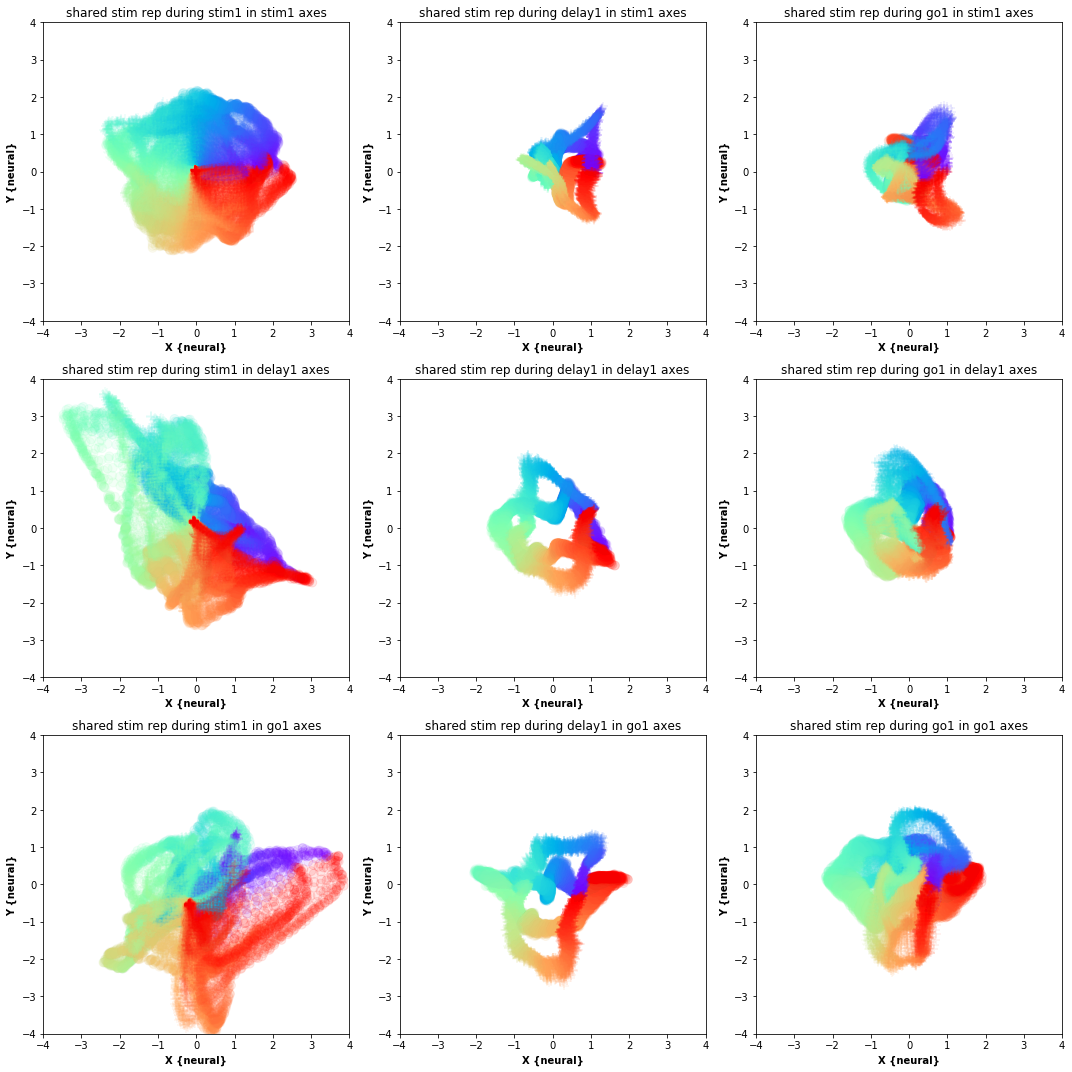

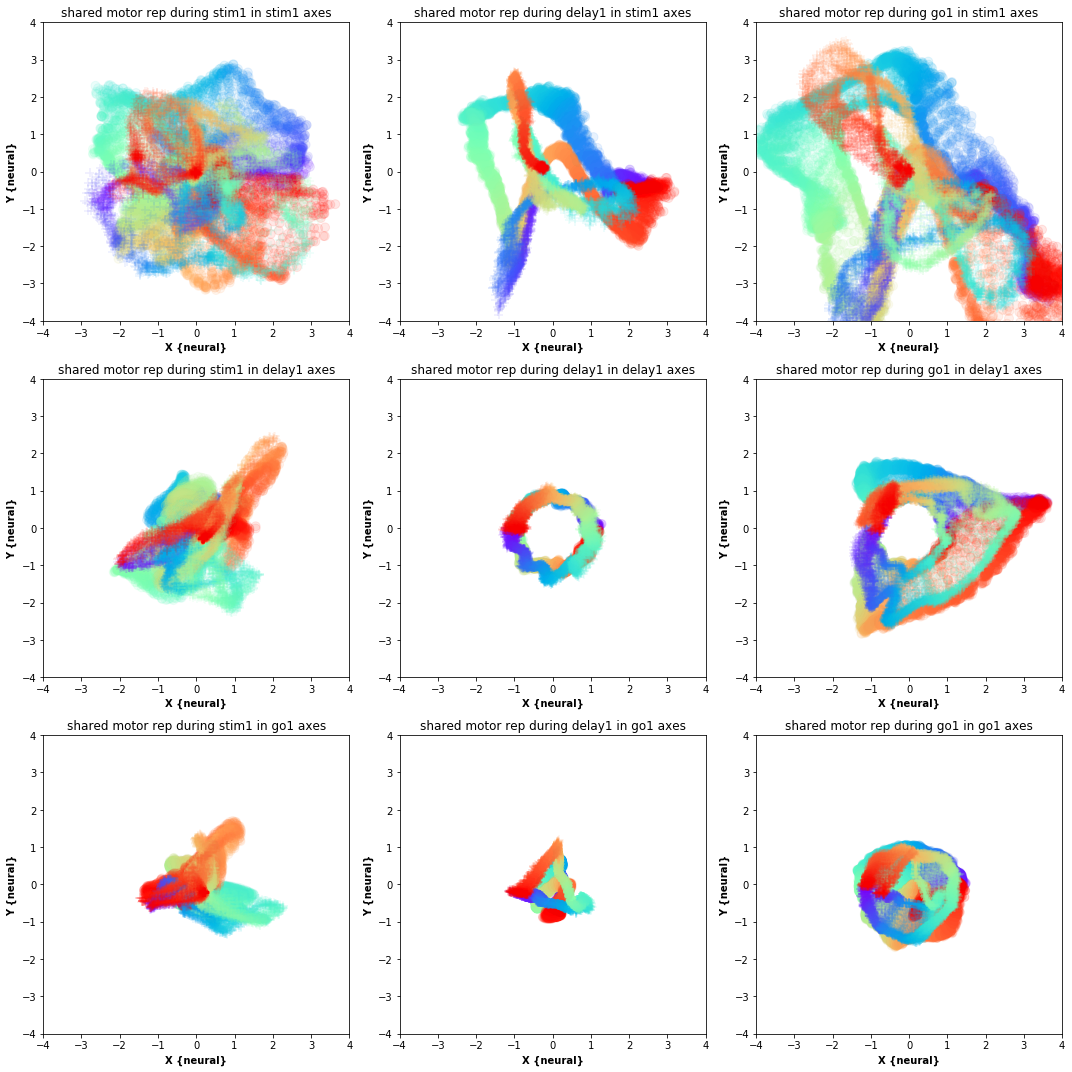

In [15]:
FIG_WIDTH = 15 # inches
FIG_HEIGHT = 15 # inches
FONT_WEIGHT = 'bold'

fig = plt.figure(figsize=(FIG_WIDTH, FIG_HEIGHT),tight_layout=True,facecolor='white')
x = 0
for epoch1 in ['stim1','delay1','go1']:
    for epoch2 in['stim1','delay1','go1']:
        x+=1
        ax = fig.add_subplot(3,3,x)
        plt.scatter(X_stim_11_oc[epoch1,epoch2][0],X_stim_11_oc[epoch1,epoch2][1],s =80,c=np.squeeze((stim_locs_Y*100)), marker='o', cmap='rainbow',alpha=.1)
        plt.scatter(X_stim_12_oc[epoch1,epoch2][0],X_stim_12_oc[epoch1,epoch2][1],s =80,c=np.squeeze((stim_locs_Y*100)), marker='+', cmap='rainbow',alpha=.1)
        ax.set_xlabel('X {neural}', fontweight=FONT_WEIGHT)
        ax.set_ylabel('Y {neural}', fontweight=FONT_WEIGHT)
        ax.set_title('shared stim rep during ' + epoch2 + ' in ' + epoch1 + ' axes')
        ax.set_xlim(-4, 4)
        ax.set_ylim(-4, 4)
        
fig = plt.figure(figsize=(FIG_WIDTH, FIG_HEIGHT),tight_layout=True,facecolor='white')
x = 0
for epoch1 in ['stim1','delay1','go1']:
    for epoch2 in['stim1','delay1','go1']:
        x+=1
        ax = fig.add_subplot(3,3,x)
        plt.scatter(X_motor_11_oc[epoch1,epoch2][0],X_motor_11_oc[epoch1,epoch2][1],s =80,c=np.squeeze((stim_locs_Y*100)), marker='o', cmap='rainbow',alpha=.1)
        plt.scatter(X_motor_12_oc[epoch1,epoch2][0],X_motor_12_oc[epoch1,epoch2][1],s =80,c=np.squeeze((stim_locs_Y*100)), marker='+', cmap='rainbow',alpha=.1)
        ax.set_xlabel('X {neural}', fontweight=FONT_WEIGHT)
        ax.set_ylabel('Y {neural}', fontweight=FONT_WEIGHT)
        ax.set_title('shared motor rep during ' + epoch2 + ' in ' + epoch1 + ' axes')
        ax.set_xlim(-4, 4)
        ax.set_ylim(-4, 4)

In [4]:
rule1 = 'delaygo' #'delaydm1'
rule2 = 'delayanti' #''delaydm2'
# stim1, coh = gen_stim_loc_delaydm()
model_n = 16
range_size=30

model_path = '/home/laura/data/multitask/train_all'
model_dir = os.path.join(model_path, str(model_n))

_, trial = gen_X_from_model_dir(model_dir,rule1)  
stim_locs = gen_stim_loc(trial)
stim_locs_rep = np.matlib.repmat(stim_locs, trial.y.shape[0], 1)
stim_locs_Y = np.reshape(stim_locs_rep.T,(1,-1))
stim_locs_Y_double = np.concatenate((stim_locs_Y,stim_locs_Y),axis=1)
targ_locs_Y_double = np.concatenate((stim_locs_Y,stim_locs_Y+np.pi)%(2*np.pi),axis=1)

data1, trial = gen_X_from_model_dir(model_dir,rule1)    
data2, trial = gen_X_from_model_dir(model_dir,rule2)
data = np.concatenate((data1,data2),axis=1)
        
uptrial = stim_locs_Y_double==0
downtrial = np.abs(stim_locs_Y_double-np.pi)<.01

pcar = PCA(n_components=30)
pcar.fit(data[:,np.squeeze(uptrial+downtrial)].T)
X = pcar.transform(data.T)

color = ['r','r','b','b','r','r','b','b']
dash = ['-','-','-','-',':',':',':',':']

fig = plt.figure(figsize=(15, 15),tight_layout=True,facecolor='white')
for t in range(8):
    inds = range(trial.y.shape[0]*t, trial.y.shape[0]*(t+1)) 
    
    for pc_set in range(9):
        ax = fig.add_subplot(3,3,pc_set+1)
        pc1 = pc_set*2
        pc2 = pc_set*2+1
        plt.plot(X[inds,pc1],X[inds,pc2],dash[t]+color[t],linewidth=2)
        plt.plot(X[inds[0]-1+trial.epochs['stim1'][0],pc1],X[inds[0]-1+trial.epochs['stim1'][0],pc2],'ok',markersize=12)
        plt.plot(X[inds[0]-1+trial.epochs['stim1'][1],pc1],X[inds[0]-1+trial.epochs['stim1'][1],pc2],'o',color = (.25,.25,.25),markersize=12)
        plt.plot(X[inds[0]-1+trial.epochs['go1'][0],pc1],X[inds[0]-1+trial.epochs['go1'][0],pc2],'o',color = (.5,.5,.5), markersize=12)
        plt.plot(X[inds[0]-1+trial.y.shape[0],pc1],X[inds[0]-1+trial.y.shape[0],pc2],'o',color = (.75,.75,.75), markersize=12)
        ax.set_xlabel('PC '+ str(pc1+1), fontweight=FONT_WEIGHT)
        ax.set_ylabel('PC '+ str(pc2+1), fontweight=FONT_WEIGHT)
#         ax.set_xlim(-2, 2)
#         ax.set_ylim(-2, 2)


Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(341, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 33) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(33,) dtype=float32_ref>


InternalError: CUDA runtime implicit initialization on GPU:0 failed. Status: out of memory

In [22]:
model_n = 0
n_models = 20
n_units = 256

# rule_list = rules_dict['all']
# n_rules = np.shape(rule_list)[0]
tasks = [2]#[1, 6, 7, 2, 11, 12]
range_size = 25
epoch0 = 'delay1'
epoch1 = 'stim1'
n_comp_keep = 20
n_pcs = 20

# ev_train_all = np.zeros((n_rules,n_models,256))
# ev_train_single = np.zeros((n_rules,n_models,256))

# for task_num in tasks:
rule = 'delaygo'#rule_list[task_num]
trial = gen_trials_from_model_dir(os.path.join('/home/laura/data/multitask/train_all',str(model_n)),rule)

for model_n in range(0,1):

    model_path_all = os.path.join('/home/laura/data/multitask/train_all',str(model_n))
    model_path_single = os.path.join('/home/laura/code/yangnet/data/sub_training/',rule,str(20+model_n))

    #epoch0
    X,trial = gen_X_from_model_dir_epoch(model_path_all,rule,epoch0,range_size,trial)
    row_means = np.mean(X, axis=1)
    X_center = X - row_means.reshape(X.shape[0],1)
    
    pcal = PCA(n_components=n_pcs)
    pcal.fit(X_center.T)
    X_low = pcal.transform(X_center.T)
            
    pca = PCA()
    pca.fit(X_low)
    epoch0_ev = pca.explained_variance_
    epoch0_comp = pca.components_[0:n_comp_keep,:]

    #epoch1
    X,trial = gen_X_from_model_dir_epoch(model_path_all,rule,epoch1,range_size,trial)
    row_means = np.mean(X, axis=1)
    X_center = X - row_means.reshape(X.shape[0],1)
    
    pcal = PCA(n_components=n_pcs)
    pcal.fit(X_center.T)
    X_low = pcal.transform(X_center.T)
            
    pca = PCA()
    pca.fit(X_low)
    epoch1_ev = pca.explained_variance_
    epoch1_comp = pca.components_[0:n_comp_keep,:]

    LA.subspace_angles(epoch0_comp,epoch1_comp)

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(341, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 33) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(33,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /home/laura/data/multitask/train_all/0/model.ckpt
INFO:tensorflow:Restoring parameters from /home/laura/data/multitask/train_all/0/model.ckpt
Model restored from file: /home/laura/data/multitask/train_all/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(341, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 33) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(33,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /home/laura/data/multitask/train_all/0/model.ckpt
INFO:tensorflow:Restoring parame

In [23]:
print(LA.subspace_angles(epoch0_comp,epoch1_comp))

[5.8555656e-07 4.6898325e-07 4.1351058e-07 3.6557950e-07 3.5083517e-07
 3.2615125e-07 2.7958134e-07 2.3436675e-07 2.2576872e-07 1.9451446e-07
 1.7447518e-07 1.3069527e-07 1.2661691e-07 9.1442296e-08 8.7642903e-08
 3.9645165e-08 1.5221005e-08 7.4287096e-09 1.4017752e-14 2.4614297e-19]


In [12]:
print(LA.subspace_angles(epoch0_comp,epoch1_comp))

[9.9327735e-07 8.9165570e-07 7.0783790e-07 6.5993839e-07 5.8158258e-07
 5.4311249e-07 5.3692042e-07 4.8065687e-07 4.3329004e-07 4.1076410e-07
 3.6502453e-07 3.3834132e-07 3.2873550e-07 3.0437207e-07 2.6677853e-07
 2.4854862e-07 2.2827339e-07 1.9777676e-07 1.6534325e-07 1.4545148e-07
 1.2904442e-07 1.2276297e-07 1.0263847e-07 9.4176123e-08 8.1465174e-08
 5.8466959e-08 4.2789544e-08 2.7380935e-08 1.4116002e-08 9.8026129e-09]


In [19]:
print(LA.subspace_angles(epoch0_comp,epoch1_comp))

[7.09885342e-07 5.66071435e-07 4.85836324e-07 4.63214690e-07
 4.34496002e-07 4.14561896e-07 4.02424376e-07 3.71886216e-07
 3.51696229e-07 3.07053938e-07 2.82067361e-07 2.64027335e-07
 2.51229750e-07 2.23646495e-07 2.10612782e-07 1.94394175e-07
 1.74352664e-07 1.63569410e-07 1.54186807e-07 1.49898710e-07
 1.25770725e-07 1.05229297e-07 7.99805235e-08 7.50724567e-08
 4.80934013e-08 4.08455421e-08 3.17943751e-08 1.29509266e-08
 7.87030796e-09 1.38553152e-14]
